# Clustering networks

In [52]:
import warnings
from umap import UMAP
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

from collections import Counter
from hdbscan import HDBSCAN
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering, k_means, spectral_clustering
from matplotlib.cm import get_cmap
from sklearn.manifold import spectral_embedding
from sklearn.utils import check_array
%matplotlib inline

seed = 42
random_state = np.random.RandomState(seed)

Defining the network:

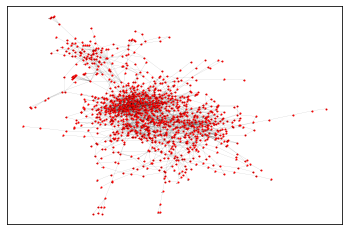

In [53]:
# G = nx.erdos_renyi_graph(50, .08, seed=seed)
G = nx.read_edgelist("air_traffic.edgelist")
# G = nx.read_edgelist("academic_collaboration.edgelist")

pos_fr = nx.fruchterman_reingold_layout(G, seed=seed)
# pos_fr = nx.spectral_layout(G)

nx.draw_networkx_nodes(G, pos=pos_fr, node_size=1, node_color='red')
nx.draw_networkx_edges(G, pos=pos_fr, width=.05)
nx.draw_networkx_labels(G, pos=pos_fr, font_size=1)
plt.show()

Reducing dimensions with Spectral Embedding and UMAP and clustering with HDBSCAN:

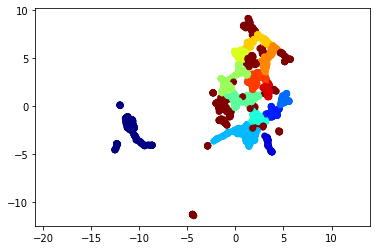

clusters: 13
noise: 0.232


In [ ]:
adj_matrix = nx.to_numpy_matrix(G)
node_list = list(G.nodes()) 

adj_matrix = check_array(adj_matrix, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64, ensure_min_samples=2)
embedding = spectral_embedding(adj_matrix, n_components=50, random_state=random_state, drop_first=False)
reducer = UMAP(n_components=2, random_state=random_state)
embedding = reducer.fit_transform(embedding)

clusters = HDBSCAN(
    min_samples=1,
    min_cluster_size=40
).fit_predict(embedding)

cmap = get_cmap('jet')(np.linspace(0, 1.0, np.amax(clusters) + 2))

plt.scatter(embedding[:, 0], embedding[:, 1], c=[cmap[clusters[i]] for i in range(len(clusters))])
plt.gca().set_aspect('equal', 'datalim')
plt.show()

print(f"clusters: {np.amax(clusters) + 1}")
print(f"noise: {np.round(Counter(clusters)[-1] / len(clusters), 3)}")

for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos=pos_fr, nodelist={node_list[i]}, node_size=1, node_color=cmap[clusters[i]])
nx.draw_networkx_edges(G, pos=pos_fr, width=.05)
nx.draw_networkx_labels(G, pos=pos_fr, font_size=1)
plt.savefig("graph.pdf")
plt.show()

Removing nodes labeled as noise by HDBSCAN:

In [ ]:
G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
node_list = list(G.nodes())
clusters = [clusters[i] for i in range(len(clusters)) if clusters[i] != -1]

for i in range(len(node_list)):
    nx.draw_networkx_nodes(G, pos=pos_fr, nodelist={node_list[i]}, node_size=1, node_color=cmap[clusters[i]])
nx.draw_networkx_edges(G, pos=pos_fr, width=.05)
nx.draw_networkx_labels(G, pos=pos_fr, font_size=1)
plt.savefig("graph2.pdf")